# Auxiliary potential fields

Here, we'll demonstrate a solution of Laplace's equation,
with Neumann boundary conditions on a surface. Similar to the
Dirichlet problem in A Dirichlet Poisson problem, we will solve the
problem with one Neumann condition external to the surface,
and another Neumann value internal to the surface.

Our underlying problem is still

$$\nabla^2\varphi^+ = 0,\qquad \nabla^2\varphi^- = 0$$

where $+$ denotes the exterior and $-$ the interior of the surface. (We will
consider a circle of radius 1.) The boundary conditions on this surface are

$$\mathbf{n}\cdot\nabla\varphi^+ = v^+_n, \qquad \mathbf{n}\cdot\nabla\varphi^- = v^-_n$$

In other words, we seek to set the value on the exterior normal derivative to $v_n$
of the local normal vector on the surface, while the interior should have zero normal
derivative.

Discretizing this problem by the usual techniques, we seek to solve

$$\begin{bmatrix} L & D_s \\ G_s & R_n^T R_n \end{bmatrix} \begin{pmatrix} f \\ -[\phi] \end{pmatrix} = \begin{pmatrix} R [v_n] \\ \overline{v}_n \end{pmatrix}$$

where $\overline{v}_n = (v^+_n + v^-_n)/2$ and $[v_n] = v^+_n - v^-_n$. The resulting
$[\phi]$ is $f^+-f^-$.

As with the Dirichlet problem, this saddle-point problem can be solved by block-LU decomposition. First solve

$$L f^{*} = R [v_n]$$

for $f^*$. Then solve

$$-S [\phi] = \overline{v}_n - G_s f^{*}$$

for $[\phi]$, where $S = R_n^T R_n - G_s L^{-1} D_s = -C_s L^{-1}C_s^T$, and finally, compute

$$f = f^{*} + L^{-1}D_s [\phi]$$

It should be remembered that, for any scalar potential field, there is
a corresponding streamfunction $\psi$ that generates the same flow. We
can get that field, as well, with only a little bit more effort:

$$S [\psi] = C_s f^{*}$$

and then solve

$$L s = C_s^T [\phi] - \hat{C}_s^T [\psi]$$.

for the streamfunction $s$.

In [26]:
using ImmersedLayers
using Plots
using LinearAlgebra
using UnPack

## Set up the extra cache and solve function
The problem type takes the usual basic form

In [2]:
@ilmproblem NeumannPoisson scalar

The extra cache holds additional intermediate data, as well as
the Schur complement.

In [3]:
struct NeumannPoissonCache{SMT,DVT,VNT,FT,ST} <: AbstractExtraILMCache
   S :: SMT
   dvn :: DVT
   vn :: VNT
   fstar :: FT
   sstar :: ST
end

The function `prob_cache`, as before, constructs the operators and extra
cache data structures

In [4]:
function ImmersedLayers.prob_cache(prob::NeumannPoissonProblem,base_cache::BasicILMCache)
    S = create_CLinvCT(base_cache)
    dvn = zeros_surface(base_cache)
    vn = zeros_surface(base_cache)
    fstar = zeros_grid(base_cache)
    sstar = zeros_gridcurl(base_cache)
    NeumannPoissonCache(S,dvn,vn,fstar,sstar)
end

And finally, here's the steps we outlined above, used to
extend the `solve` function

In [5]:
function ImmersedLayers.solve(prob::NeumannPoissonProblem,sys::ILMSystem)
    @unpack extra_cache, base_cache, bc, phys_params = sys
    @unpack S, dvn, vn, fstar, sstar = extra_cache

    fill!(fstar,0.0)
    fill!(sstar,0.0)

    f = zeros_grid(base_cache)
    s = zeros_gridcurl(base_cache)
    df = zeros_surface(base_cache)
    ds = zeros_surface(base_cache)

    # Get the precribed jump and average of the surface normal derivatives
    prescribed_surface_jump!(dvn,sys)
    prescribed_surface_average!(vn,sys)

    # Find the potential
    regularize!(fstar,dvn,base_cache)
    inverse_laplacian!(fstar,base_cache)

    surface_grad!(df,fstar,base_cache)
    df .= vn - df
    df .= -(S\df);

    surface_divergence!(f,df,base_cache)
    inverse_laplacian!(f,base_cache)
    f .+= fstar

    # Find the streamfunction
    surface_curl!(sstar,df,base_cache)

    surface_grad_cross!(ds,fstar,base_cache)
    ds .= S\ds

    surface_curl_cross!(s,ds,base_cache)
    s .-= sstar
    s .*= -1.0

    inverse_laplacian!(s,base_cache)

    return f, df, s, ds
end

## Set up the problem

###  Set up the grid
We make the grid a bit larger than we need, because the domain outer boundary for the auxiliary potential will be an
immersed surface placed just inside the grid boundary

In [7]:
Δx = 0.01
buffer_dist = 0.1

xlim_min, xlim_max = -1.5, 5.0
ylim_min, ylim_max = -2.5, 2.5

xlim = (xlim_min-buffer_dist, xlim_max+buffer_dist)
ylim = (ylim_min-buffer_dist, ylim_max+buffer_dist)
g = PhysicalGrid(xlim,ylim,Δx,nthreads_max=6)

PhysicalGrid{2}((677, 528), (163, 264), 0.01, ((-1.62, 5.13), (-2.63, 2.63)), 6)

In [8]:
Δs = 1.4*cellsize(g);

bl = BodyList();
push!(bl,NACA4(0.0,0.0,0.12,Δs)) # The actual body is body 1

# The outer boundary is an immersed surface, body 2
halfx = 0.5*(xlim_max - xlim_min)
halfy = 0.5*(ylim_max - ylim_min)
xc, yc = 0.5*(xlim_max+xlim_min), 0.5*(ylim_max+ylim_min)
push!(bl,Rectangle(halfx,halfy,Δs)) 


# Place the bodies where you want them
t1 = MotionTransform([0.0,0.0],-π/4)  # Rotate and translate the body
t2 = MotionTransform([xc,yc],0.0) # Center the outer boundary
tl = MotionTransformList([t1,t2])
update_body!(bl,tl);

### Construct the system
We only need to do this once for a given geometry. It does not change for different choices of boundary conditon

In [ ]:
bcdict = Dict("exterior"=>get_vnplus,"interior"=>get_vnminus)

prob = NeumannPoissonProblem(g,bl,bc=bcdict)
sys = construct_system(prob);

## Solve the problem

### Set the boundary condition functions
Note that there are three different options for setting the boundary condition on body 1. You just uncomment the
one you want and then solve the problem

In [23]:
function get_vnplus(base_cache,phys_params)
    @unpack bl = base_cache
    nrm = normals(base_cache)
    pts = points(base_cache)

    vnplus = zeros_surface(base_cache)
    
    # Center of body 
    Xc, Yc = bl[1].cent
    pts.u .-= Xc
    pts.v .-= Yc
    
    # Set the condition on body 1
    
    # For x translation, use this
    copyto!(vnplus,nrm.u,base_cache,1)
    
    # For y translation, use this
    #copyto!(vnplus,nrm.v,base_cache,1)
    
    # For rotation, use this
    #copyto!(vnplus,pointwise_cross(pts,nrm),base_cache,1)
    
    return vnplus
end


function get_vnminus(base_cache,phys_params)
    vnminus = zeros_surface(base_cache)
    return vnminus
end



get_vnminus (generic function with 1 method)

### Solve it

In [24]:
f, df, s, ds = solve(prob,sys);

### Plot the field

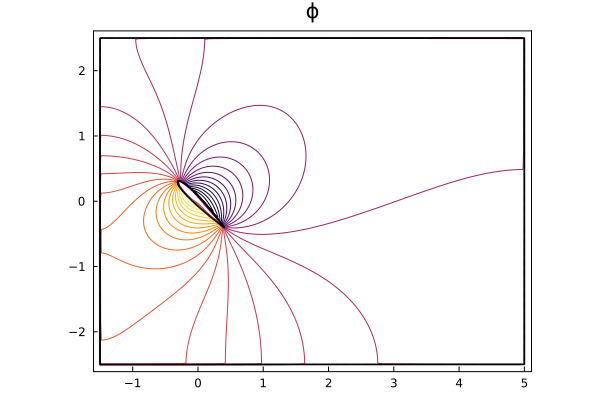

In [25]:
plot(f,sys,layers=true,levels=30,title="ϕ")

Now, let's compute the added mass components of the body associated
with this motion. We are approximating

$$M = -\int_{C_1} f^+ \mathbf{n}\mathrm{d}s$$

where $C_1$ is shape 1, and $f^+$ is simply $[\phi]$ on body 1.

In [20]:
nrm = normals(sys)
M = -integrate(df∘nrm,sys,1)

2-element Vector{Float64}:
 0.02545843250169798
 0.02548736601658188

As one would expect, the circle has added mass in the $x$ direction
associated with moving in that direction.

---

*This notebook was generated using [Literate.jl](https://github.com/fredrikekre/Literate.jl).*